# Forecasting Wind Power Generation

## 1. Import Libraries

In [1]:
!pip install dython

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import math

from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from dython.nominal import identify_nominal_columns
from dython.nominal import associations
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model

pd.set_option('display.max_columns', None)


## 2. Loading data to dataframe

In [46]:
energy_dataframe = pd.read_csv('energy_dataset.csv')
pd.set_option('display.max_columns', None)
print(energy_dataframe.shape)
energy_dataframe.head()

(35064, 29)


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [47]:
weather_cities = pd.read_csv('weather_features.csv')
print(weather_cities.shape)
weather_cities.head(5)

(178396, 17)


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


## 3. Check for null, 0, Nan, duplicate values in both dataframes

In [48]:
energy_dataframe.isna().sum(axis=0)

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [49]:
energy_dataframe.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


**Observation:**
<ul>
<li>Unwanted Columns to be removed are 'generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine', 'generation wind offshore', 'forecast wind offshore eday ahead'.
</ul>

In [50]:
# dropping columns with 'nan' values

energy_dataframe = energy_dataframe.drop(['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat',
                                          'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine',
                                          'generation wind offshore', 'forecast wind offshore eday ahead'], axis=1)


In [51]:
# checking for duplicated columns in energy_dataframe

duplicate_energy_dataframe = energy_dataframe[energy_dataframe.duplicated()]
print('The length of the duplicated dataframe', len(duplicate_energy_dataframe))
print('The length of the actual dataframe', len(energy_dataframe))

The length of the duplicated dataframe 0
The length of the actual dataframe 35064


**Observation:**

<ul>
<li>There is no null values in energy_dataframe dataframe

In [52]:
weather_cities.isna().sum(axis=0)

dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [53]:
# checking for duplicated columns in weather_cities

duplicate_weather_cities = weather_cities[weather_cities.duplicated()]
print('The length of weather_cities dataframe with duplicates are', len(weather_cities))
print('The duplicate records present in dataframe is', len(duplicate_weather_cities))

The length of weather_cities dataframe with duplicates are 178396
The duplicate records present in dataframe is 21


In [54]:
duplicate_weather_cities.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
125,2015-01-06 04:00:00+01:00,Valencia,273.142,273.142,273.142,995,86,1,265,0.0,0.0,0.0,0,800,clear,sky is clear,01n
6566,2015-10-01 02:00:00+02:00,Valencia,289.740,286.480,292.040,1021,88,0,0,0.0,0.0,0.0,40,802,clouds,scattered clouds,03n
15345,2016-09-30 02:00:00+02:00,Valencia,288.060,285.370,291.250,1021,86,1,45,0.0,0.0,0.0,0,800,clear,sky is clear,01n
24135,2017-09-30 02:00:00+02:00,Valencia,292.150,292.150,292.150,1021,82,0,0,0.0,0.0,0.0,20,801,clouds,few clouds,02n
32900,2018-09-30 02:00:00+02:00,Valencia,292.150,292.150,292.150,1017,82,2,320,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [55]:
# removing duplicate records from dataframe

print('The length of weather_cities dataframe with duplicates are', len(weather_cities))
weather_cities = weather_cities.drop_duplicates(subset = ['dt_iso', 'city_name'], keep = 'first', ignore_index=False)
duplicate_weather_cities = weather_cities[weather_cities.duplicated()]
print('The duplicate records present in dataframe now is', len(duplicate_weather_cities))
print('The length of weather_cities dataframe after removing duplicates are', len(weather_cities))

The length of weather_cities dataframe with duplicates are 178396
The duplicate records present in dataframe now is 0
The length of weather_cities dataframe after removing duplicates are 175320


## 4. Imputing the null values or '0' values in a column in dataframe

In [56]:
energy_dataframe.isna().sum(axis=0)

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0


In [57]:
# Fill null values using interpolation

energy_dataframe.interpolate(method='linear', limit_direction='both', inplace=True, axis=0)
energy_dataframe.isna().sum(axis=0)

time                                           0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual        

## 5. Detect outliers in the dataframe

In [58]:
energy_dataframe.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.531343,448.094570,5622.700647,4256.531271,298.342417,475.582706,972.201902,2605.534123,6263.483430,60.226030,85.634326,1432.818546,269.418692,5464.980450,1439.066735,5471.216689,28712.129962,28698.281385,49.874341,57.884023
std,85.346266,354.618269,2201.510984,1961.988937,52.519927,792.312704,400.712304,1835.175078,840.272333,20.238792,14.076948,1679.961733,50.218423,3213.586296,1677.703355,3176.312853,4594.100854,4575.828854,14.618900,14.204083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1078.000000,5759.000000,53.000000,73.000000,71.000000,240.000000,2933.000000,69.000000,2979.000000,24793.750000,24807.000000,41.490000,49.347500
50%,367.000000,509.000000,4969.500000,4475.000000,300.000000,68.000000,906.000000,2165.000000,6564.000000,57.000000,88.000000,616.000000,279.000000,4849.500000,576.000000,4855.000000,28906.000000,28902.000000,50.520000,58.020000
75%,433.000000,757.000000,6429.000000,5839.000000,330.000000,616.000000,1250.000000,3758.000000,7025.000000,80.000000,97.000000,2579.000000,310.000000,7399.500000,2636.000000,7353.000000,32263.250000,32194.250000,60.530000,68.010000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,119.000000,5792.000000,357.000000,17436.000000,5836.000000,17430.000000,41390.000000,41015.000000,101.990000,116.800000


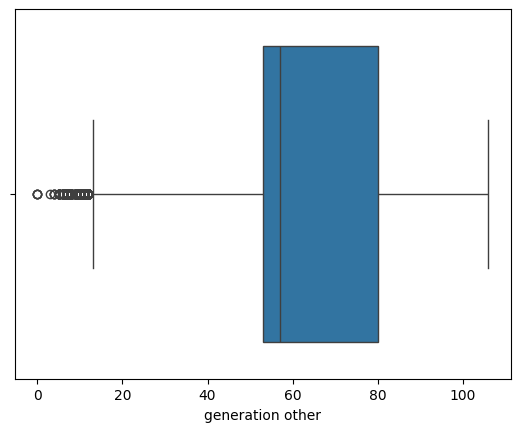

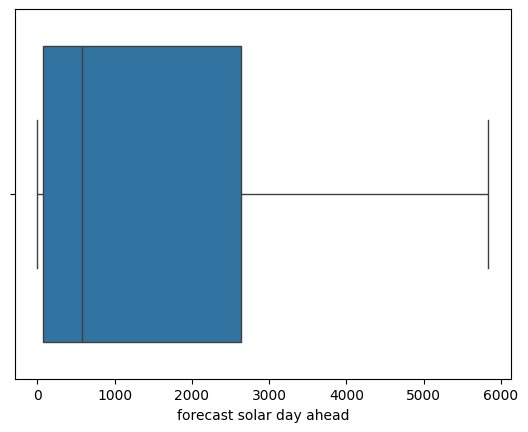

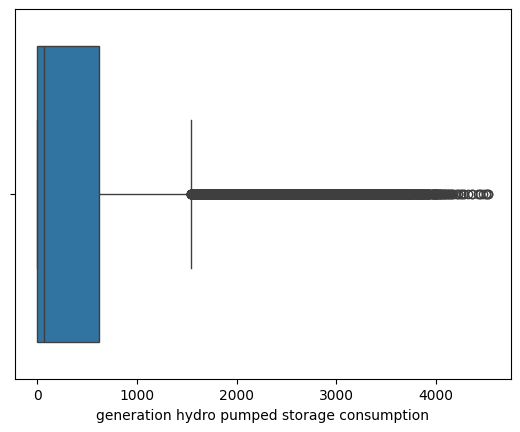

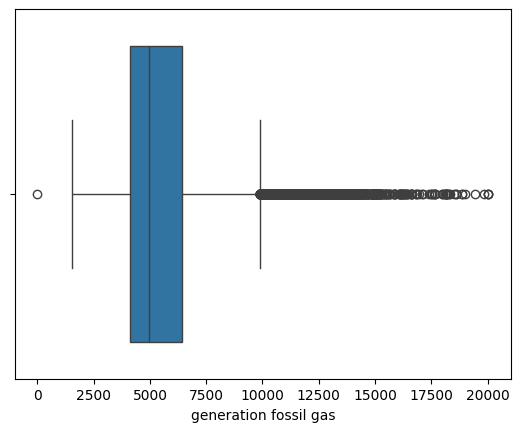

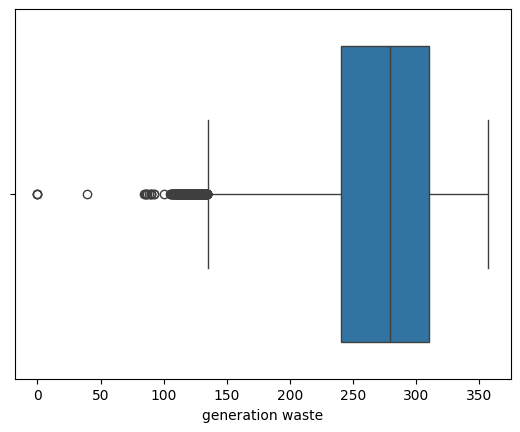

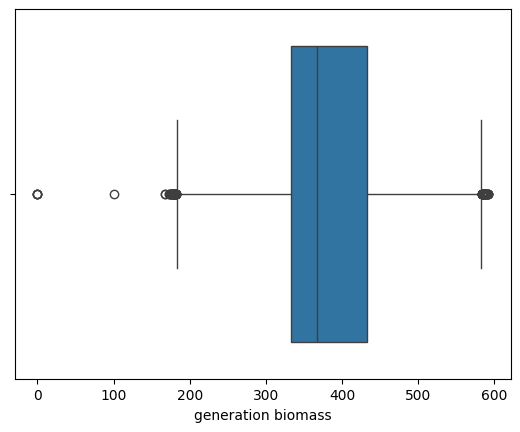

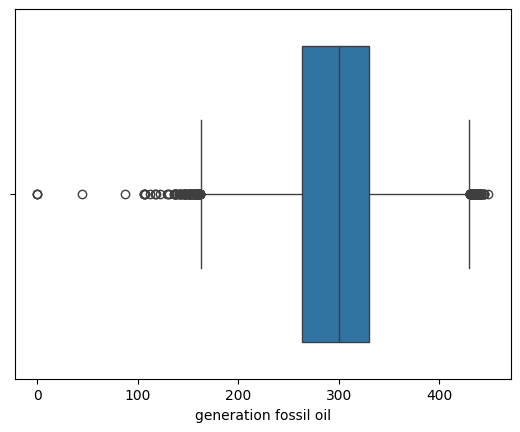

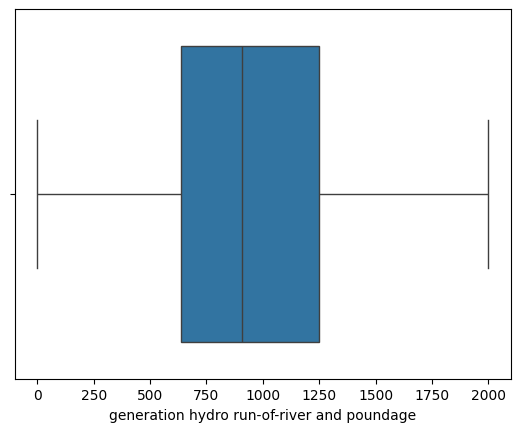

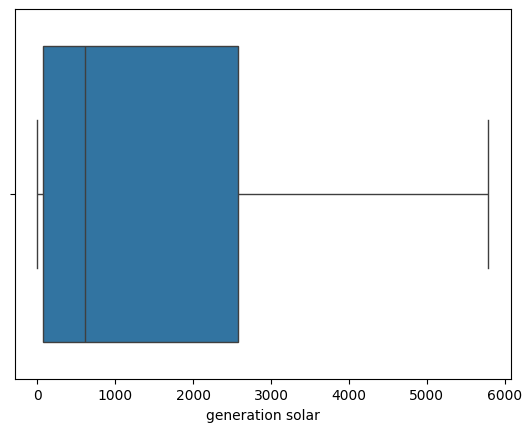

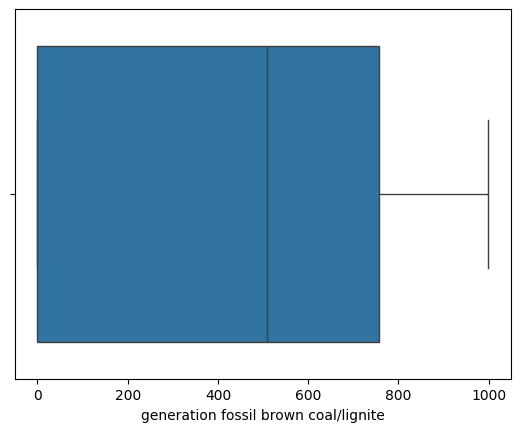

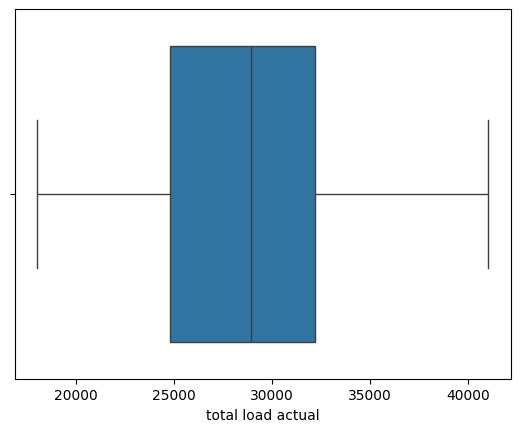

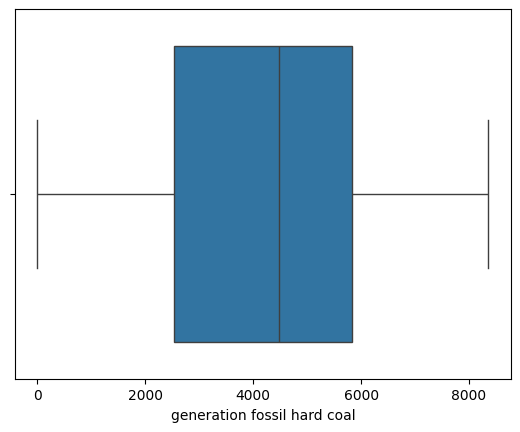

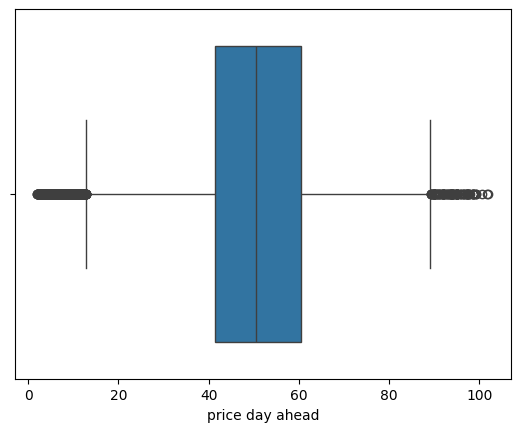

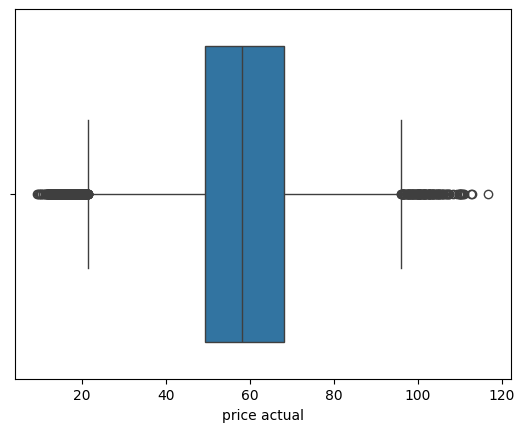

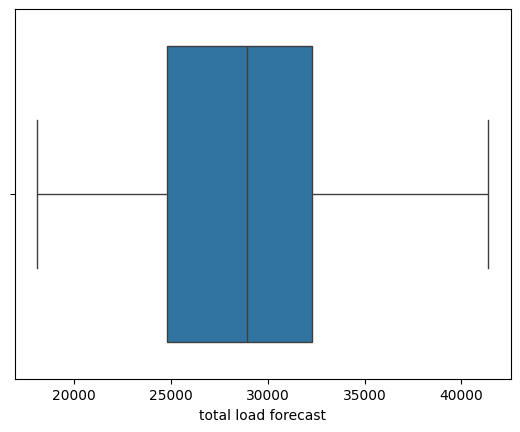

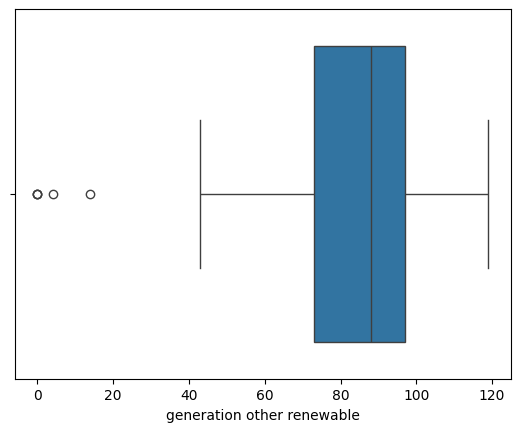

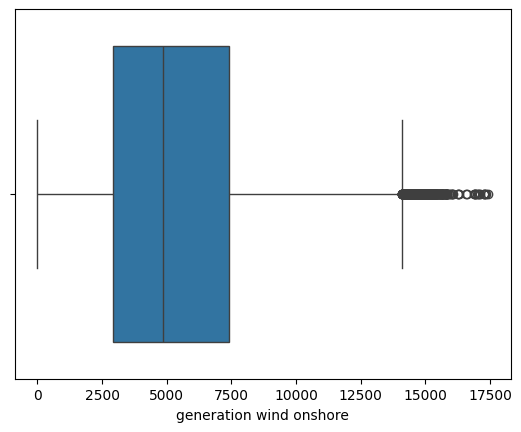

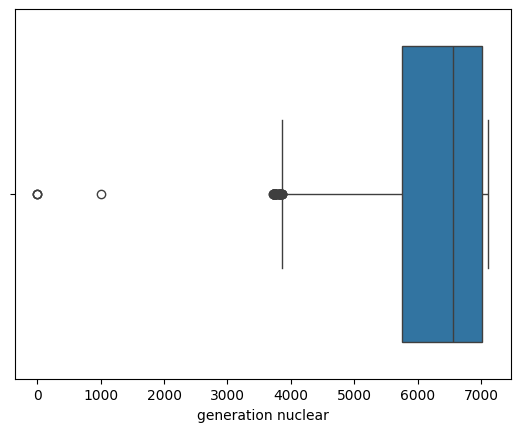

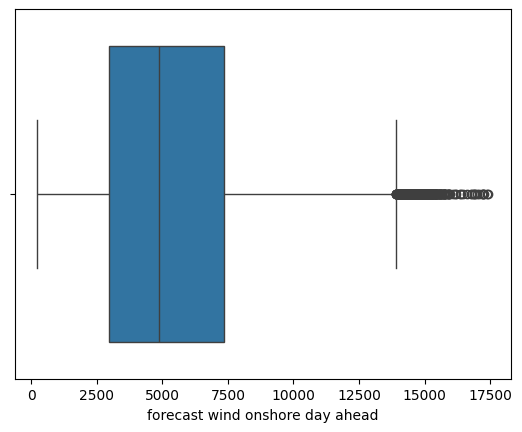

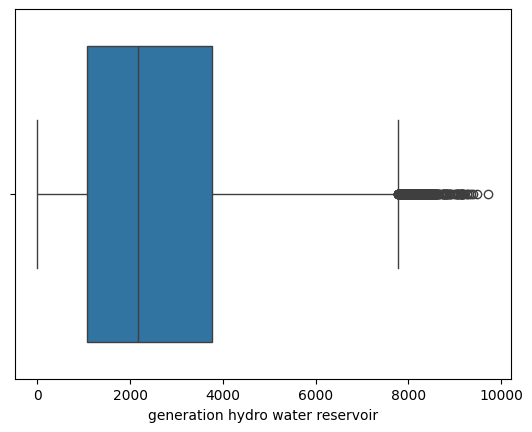

In [59]:
for i in list(set(list(energy_dataframe.columns)) - set(['time'])):
  sns.boxplot(x=energy_dataframe[i])
  plt.show()

In [60]:
weather_cities.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,175320.000000,175320.000000,175320.000000,1.753200e+05,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000
mean,289.707651,288.428433,291.172255,1.070199e+03,68.032307,2.470009,166.724909,0.069308,0.000386,0.004846,24.344057,763.452390
std,8.024910,7.948249,8.613916,6.021769e+03,21.838097,2.095140,116.548788,0.385915,0.007348,0.224547,30.339522,103.125539
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.830000,282.784586,284.909258,1.013000e+03,53.000000,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.000000,178.000000,0.000000,0.000000,0.000000,16.000000,800.000000
75%,295.240000,294.150000,297.150000,1.022000e+03,87.000000,4.000000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.000000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


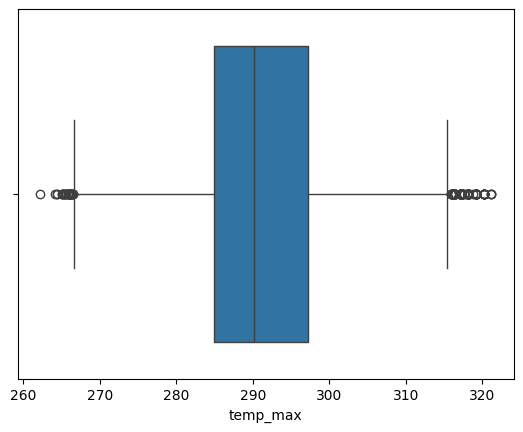

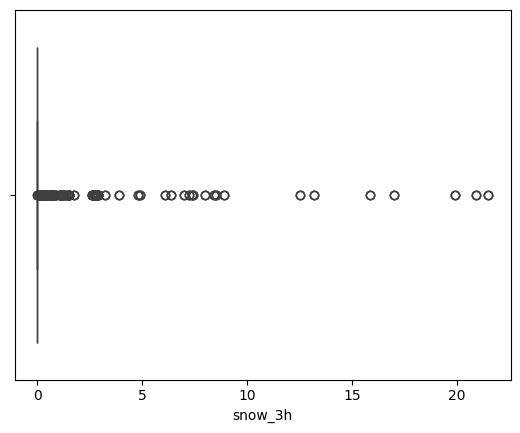

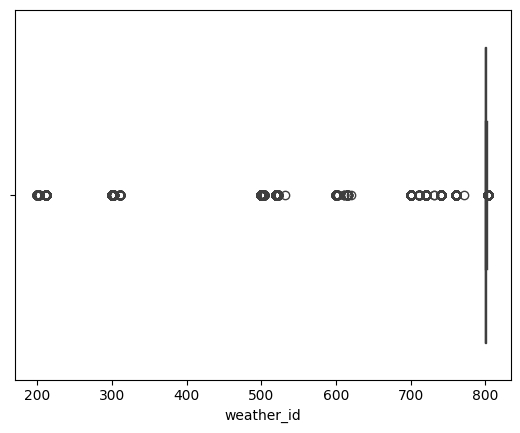

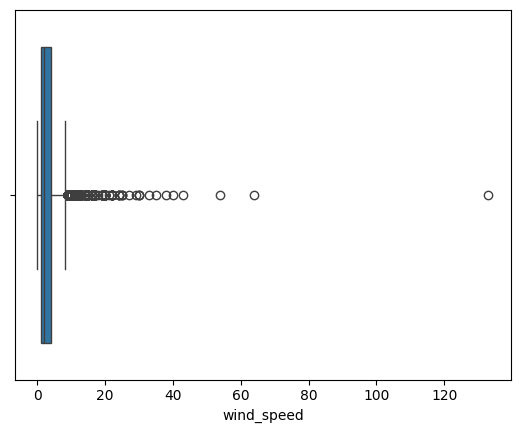

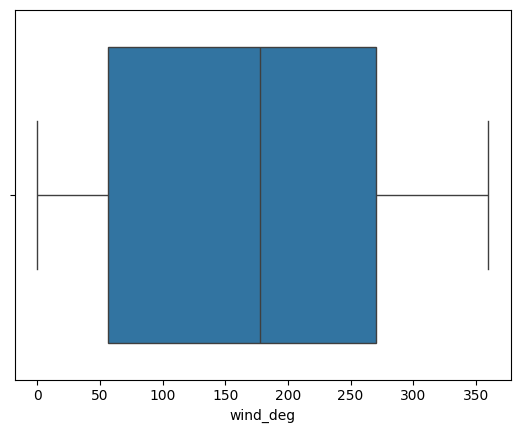

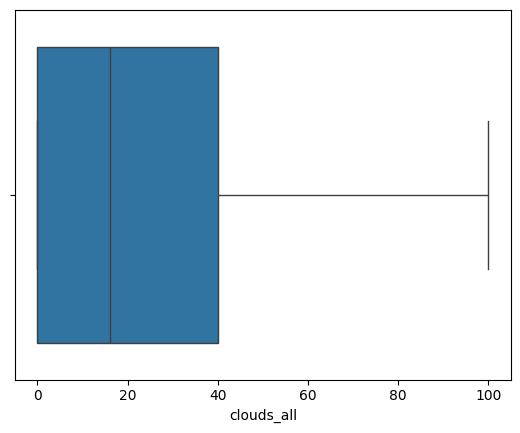

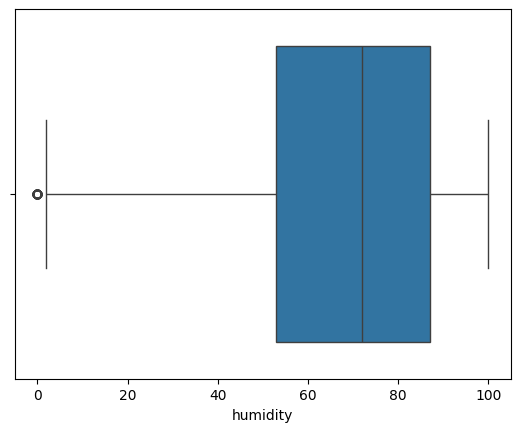

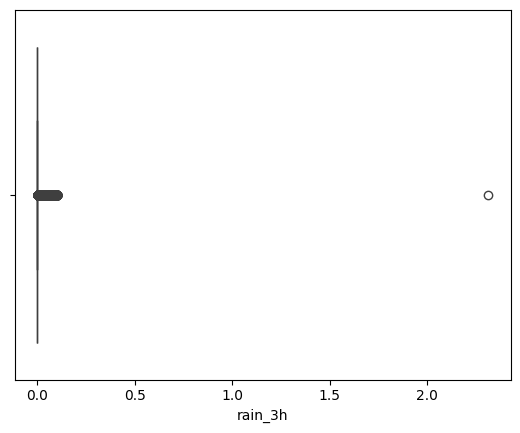

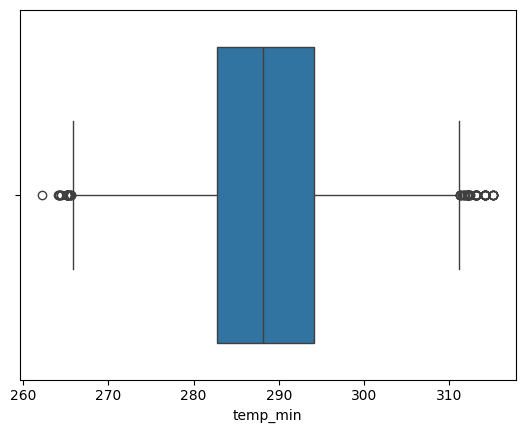

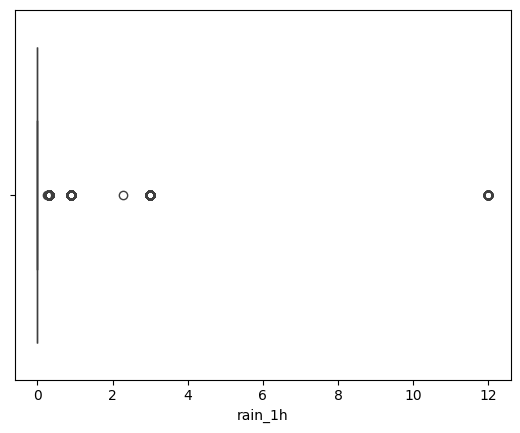

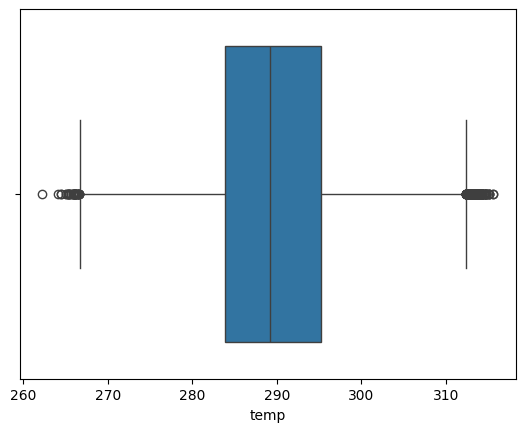

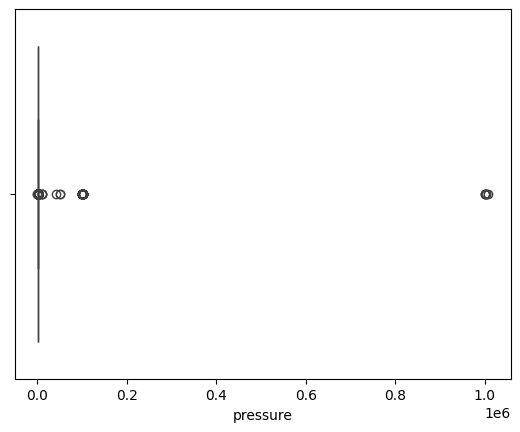

In [61]:
numerical_weather_columns = list(set(list(weather_cities.columns)) - set(['dt_iso', 'city_name', 'weather_main', 'weather_description', 'weather_icon']))

for i in numerical_weather_columns:
  sns.boxplot(x = weather_cities[i])
  plt.show()

**Observation:**
<ul>
<li>We can see that the columns 'wind_speed' and 'pressure' may have outliers.

In [62]:
# Replace outliers in 'pressure' with NaNs

weather_cities.loc[weather_cities.pressure > 1040, 'pressure'] = np.nan
weather_cities.loc[weather_cities.pressure < 960, 'pressure'] = np.nan

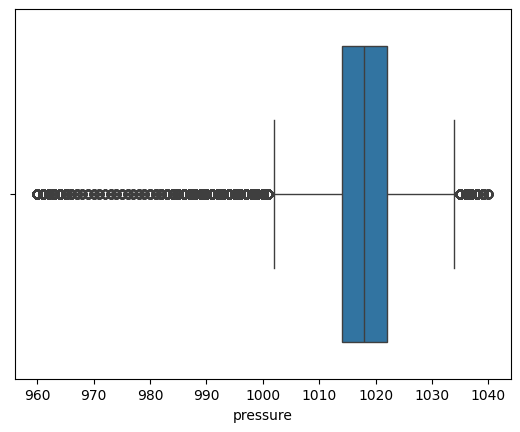

In [63]:
sns.boxplot(x = weather_cities['pressure'])
plt.show()

In [64]:
# Replace outliers in 'wind_speed' with NaNs

weather_cities.loc[weather_cities.wind_speed > 70, 'wind_speed'] = np.nan

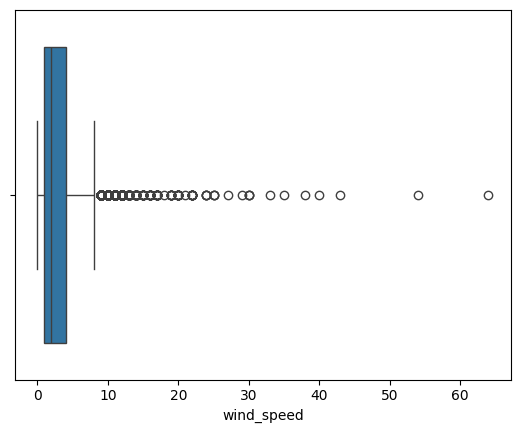

In [65]:
sns.boxplot(x = weather_cities['wind_speed'])
plt.show()

In [66]:
# Imputing the Nan values

weather_cities.interpolate(method='linear', limit_direction='both', inplace=True, axis=0)

## 6. Modifying the weather dataset according to the cities

In [67]:
weather_data = weather_cities[['weather_main', 'weather_id', 'weather_description', 'weather_icon']]
weather_data.head()


,weather_main,weather_id,weather_description,weather_icon
0,clear,800,sky is clear,01n
1,clear,800,sky is clear,01n
2,clear,800,sky is clear,01n
3,clear,800,sky is clear,01n
4,clear,800,sky is clear,01n


In [68]:
categorical_features = identify_nominal_columns(weather_data)
categorical_features

['weather_main', 'weather_description', 'weather_icon']

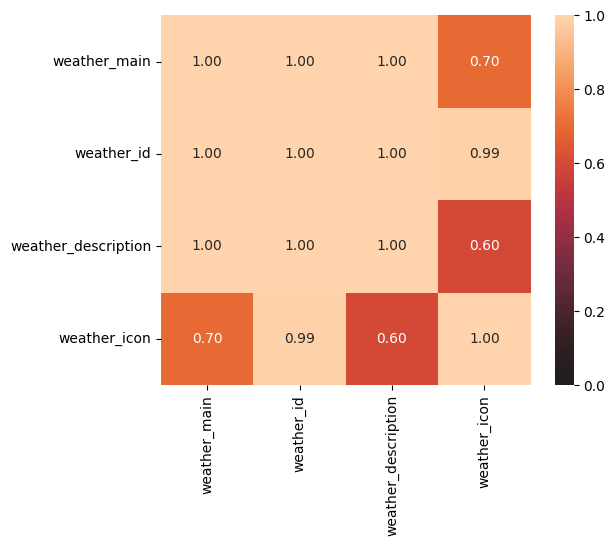

{'corr':                      weather_main  weather_id  weather_description  \
 weather_main             1.000000    0.999830             0.999917   
 weather_id               0.999830    1.000000             1.000000   
 weather_description      0.999917    1.000000             1.000000   
 weather_icon             0.699959    0.991071             0.599294   
 
                      weather_icon  
 weather_main             0.699959  
 weather_id               0.991071  
 weather_description      0.599294  
 weather_icon             1.000000  ,
 'ax': <Axes: >}

In [69]:
associations(weather_data, nominal_columns='auto', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson', ax=None, figsize=None, annot=True, fmt='.2f', cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None, plot=True, compute_only=False, clustering=False, title=None, filename=None)

**Observation:**
<ol>
<li>We can observe that there is high correlation among all the columns of the weather data.
<li>Hence we can take weather id and drop all others columns.
</ol>

In [70]:
weather_cities = weather_cities.drop(columns = ['weather_main', 'weather_description', 'weather_icon'], axis=1)

weather_cities_city_name = weather_cities.groupby('city_name')
weather_Valencia = weather_cities_city_name.get_group('Valencia')
weather_Valencia = weather_Valencia.add_prefix('Valencia_')
weather_Madrid = weather_cities_city_name.get_group('Madrid')
weather_Madrid = weather_Madrid.add_prefix('Madrid_')
weather_Bilbao = weather_cities_city_name.get_group('Bilbao')
weather_Bilbao = weather_Bilbao.add_prefix('Bilbao_')
weather_Barcelona = weather_cities_city_name.get_group(' Barcelona')
weather_Barcelona = weather_Barcelona.add_prefix('Barcelona_')
weather_Seville = weather_cities_city_name.get_group('Seville')
weather_Seville = weather_Seville.add_prefix('Seville_')

In [71]:
weather_Valencia.rename(columns = {'Valencia_dt_iso':'time'}, inplace = True)
weather_Madrid.rename(columns = {'Madrid_dt_iso':'time'}, inplace = True)
weather_Bilbao.rename(columns = {'Bilbao_dt_iso':'time'}, inplace = True)
weather_Barcelona.rename(columns = {'Barcelona_dt_iso':'time'}, inplace = True)
weather_Seville.rename(columns = {'Seville_dt_iso':'time'}, inplace = True)

In [72]:
df_merged = weather_Valencia.merge(weather_Madrid, on = 'time').merge(weather_Bilbao, on = 'time').merge(weather_Barcelona, on = 'time').merge(weather_Seville, on = 'time')
df_merged.head()

,time,Valencia_city_name,Valencia_temp,Valencia_temp_min,Valencia_temp_max,Valencia_pressure,Valencia_humidity,Valencia_wind_speed,Valencia_wind_deg,Valencia_rain_1h,Valencia_rain_3h,Valencia_snow_3h,Valencia_clouds_all,Valencia_weather_id,Madrid_city_name,Madrid_temp,Madrid_temp_min,Madrid_temp_max,Madrid_pressure,Madrid_humidity,Madrid_wind_speed,Madrid_wind_deg,Madrid_rain_1h,Madrid_rain_3h,Madrid_snow_3h,Madrid_clouds_all,Madrid_weather_id,Bilbao_city_name,Bilbao_temp,Bilbao_temp_min,Bilbao_temp_max,Bilbao_pressure,Bilbao_humidity,Bilbao_wind_speed,Bilbao_wind_deg,Bilbao_rain_1h,Bilbao_rain_3h,Bilbao_snow_3h,Bilbao_clouds_all,Bilbao_weather_id,Barcelona_city_name,Barcelona_temp,Barcelona_temp_min,Barcelona_temp_max,Barcelona_pressure,Barcelona_humidity,Barcelona_wind_speed,Barcelona_wind_deg,Barcelona_rain_1h,Barcelona_rain_3h,Barcelona_snow_3h,Barcelona_clouds_all,Barcelona_weather_id,Seville_city_name,Seville_temp,Seville_temp_min,Seville_temp_max,Seville_pressure,Seville_humidity,Seville_wind_speed,Seville_wind_deg,Seville_rain_1h,Seville_rain_3h,Seville_snow_3h,Seville_clouds_all,Seville_weather_id
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0.0,0.0,0,800,Madrid,267.325,267.325,267.325,971.0,63,1.0,309,0.0,0.0,0.0,0,800,Bilbao,269.657312,269.657312,269.657312,1036.0,97,0.0,226,0.0,0.0,0.0,0,800,Barcelona,281.625,281.625,281.625,1035.0,100,7.0,58,0.0,0.0,0.0,0,800,Seville,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0.0,0.0,0,800
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0.0,0.0,0,800,Madrid,267.325,267.325,267.325,971.0,63,1.0,309,0.0,0.0,0.0,0,800,Bilbao,269.763500,269.763500,269.763500,1035.0,97,0.0,229,0.0,0.0,0.0,0,800,Barcelona,281.625,281.625,281.625,1035.0,100,7.0,58,0.0,0.0,0.0,0,800,Seville,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0.0,0.0,0,800
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,Madrid,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,Bilbao,269.251688,269.251688,269.251688,1036.0,97,1.0,224,0.0,0.0,0.0,0,800,Barcelona,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,Seville,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,Madrid,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,Bilbao,269.203344,269.203344,269.203344,1035.0,97,1.0,225,0.0,0.0,0.0,0,800,Barcelona,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,Seville,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,Madrid,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,Bilbao,269.485500,269.485500,269.485500,1035.0,97,1.0,221,0.0,0.0,0.0,0,800,Barcelona,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,Seville,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800


In [73]:
df_merged = df_merged.drop(columns = ['Valencia_city_name', 'Madrid_city_name', 'Bilbao_city_name', 'Barcelona_city_name', 'Seville_city_name'], axis = 1)
df_merged.head()


,time,Valencia_temp,Valencia_temp_min,Valencia_temp_max,Valencia_pressure,Valencia_humidity,Valencia_wind_speed,Valencia_wind_deg,Valencia_rain_1h,Valencia_rain_3h,Valencia_snow_3h,Valencia_clouds_all,Valencia_weather_id,Madrid_temp,Madrid_temp_min,Madrid_temp_max,Madrid_pressure,Madrid_humidity,Madrid_wind_speed,Madrid_wind_deg,Madrid_rain_1h,Madrid_rain_3h,Madrid_snow_3h,Madrid_clouds_all,Madrid_weather_id,Bilbao_temp,Bilbao_temp_min,Bilbao_temp_max,Bilbao_pressure,Bilbao_humidity,Bilbao_wind_speed,Bilbao_wind_deg,Bilbao_rain_1h,Bilbao_rain_3h,Bilbao_snow_3h,Bilbao_clouds_all,Bilbao_weather_id,Barcelona_temp,Barcelona_temp_min,Barcelona_temp_max,Barcelona_pressure,Barcelona_humidity,Barcelona_wind_speed,Barcelona_wind_deg,Barcelona_rain_1h,Barcelona_rain_3h,Barcelona_snow_3h,Barcelona_clouds_all,Barcelona_weather_id,Seville_temp,Seville_temp_min,Seville_temp_max,Seville_pressure,Seville_humidity,Seville_wind_speed,Seville_wind_deg,Seville_rain_1h,Seville_rain_3h,Seville_snow_3h,Seville_clouds_all,Seville_weather_id
0,2015-01-01 00:00:00+01:00,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0.0,0.0,0,800,267.325,267.325,267.325,971.0,63,1.0,309,0.0,0.0,0.0,0,800,269.657312,269.657312,269.657312,1036.0,97,0.0,226,0.0,0.0,0.0,0,800,281.625,281.625,281.625,1035.0,100,7.0,58,0.0,0.0,0.0,0,800,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0.0,0.0,0,800
1,2015-01-01 01:00:00+01:00,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0.0,0.0,0,800,267.325,267.325,267.325,971.0,63,1.0,309,0.0,0.0,0.0,0,800,269.763500,269.763500,269.763500,1035.0,97,0.0,229,0.0,0.0,0.0,0,800,281.625,281.625,281.625,1035.0,100,7.0,58,0.0,0.0,0.0,0,800,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0.0,0.0,0,800
2,2015-01-01 02:00:00+01:00,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,269.251688,269.251688,269.251688,1036.0,97,1.0,224,0.0,0.0,0.0,0,800,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800
3,2015-01-01 03:00:00+01:00,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,269.203344,269.203344,269.203344,1035.0,97,1.0,225,0.0,0.0,0.0,0,800,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800
4,2015-01-01 04:00:00+01:00,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,269.485500,269.485500,269.485500,1035.0,97,1.0,221,0.0,0.0,0.0,0,800,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800


In [74]:
df_merged = df_merged.merge(energy_dataframe, on = 'time')
df_merged.head()

,time,Valencia_temp,Valencia_temp_min,Valencia_temp_max,Valencia_pressure,Valencia_humidity,Valencia_wind_speed,Valencia_wind_deg,Valencia_rain_1h,Valencia_rain_3h,Valencia_snow_3h,Valencia_clouds_all,Valencia_weather_id,Madrid_temp,Madrid_temp_min,Madrid_temp_max,Madrid_pressure,Madrid_humidity,Madrid_wind_speed,Madrid_wind_deg,Madrid_rain_1h,Madrid_rain_3h,Madrid_snow_3h,Madrid_clouds_all,Madrid_weather_id,Bilbao_temp,Bilbao_temp_min,Bilbao_temp_max,Bilbao_pressure,Bilbao_humidity,Bilbao_wind_speed,Bilbao_wind_deg,Bilbao_rain_1h,Bilbao_rain_3h,Bilbao_snow_3h,Bilbao_clouds_all,Bilbao_weather_id,Barcelona_temp,Barcelona_temp_min,Barcelona_temp_max,Barcelona_pressure,Barcelona_humidity,Barcelona_wind_speed,Barcelona_wind_deg,Barcelona_rain_1h,Barcelona_rain_3h,Barcelona_snow_3h,Barcelona_clouds_all,Barcelona_weather_id,Seville_temp,Seville_temp_min,Seville_temp_max,Seville_pressure,Seville_humidity,Seville_wind_speed,Seville_wind_deg,Seville_rain_1h,Seville_rain_3h,Seville_snow_3h,Seville_clouds_all,Seville_weather_id,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0.0,0.0,0,800,267.325,267.325,267.325,971.0,63,1.0,309,0.0,0.0,0.0,0,800,269.657312,269.657312,269.657312,1036.0,97,0.0,226,0.0,0.0,0.0,0,800,281.625,281.625,281.625,1035.0,100,7.0,58,0.0,0.0,0.0,0,800,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0.0,0.0,0,800,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0.0,0.0,0,800,267.325,267.325,267.325,971.0,63,1.0,309,0.0,0.0,0.0,0,800,269.763500,269.763500,269.763500,1035.0,97,0.0,229,0.0,0.0,0.0,0,800,281.625,281.625,281.625,1035.0,100,7.0,58,0.0,0.0,0.0,0,800,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0.0,0.0,0,800,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,269.251688,269.251688,269.251688,1036.0,97,1.0,224,0.0,0.0,0.0,0,800,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,269.203344,269.203344,269.203344,1035.0,97,1.0,225,0.0,0.0,0.0,0,800,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,269.485500,269.485500,269.485500,1035.0,97,1.0,221,0.0,0.0,0.0,0,800,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04


In [75]:
df_merged = df_merged.drop(columns = ['Seville_snow_3h', 'Barcelona_snow_3h'])

df_merged['year'] = df_merged['time'].str[:4].astype(int)
df_merged['month'] = df_merged['time'].str[5:7].astype(int)
df_merged['day'] = df_merged['time'].str[8:10].astype(int)
df_merged['hour'] = df_merged['time'].str[11:13].astype(int)

replacements = {1 : 'January', 2 : 'February', 3 : 'March', 4 : 'April', 5 : 'May', 6 : 'June',
                7 : 'July', 8 : 'August', 9 : 'Spetember', 10 : 'October', 11 : 'November', 12 : 'December'}

# Replace multiple values in column 'B' using the dictionary
df_merged['month'].replace(replacements, inplace=True)

In [76]:
print(df_merged.columns)

Index(['time', 'Valencia_temp', 'Valencia_temp_min', 'Valencia_temp_max',
       'Valencia_pressure', 'Valencia_humidity', 'Valencia_wind_speed',
       'Valencia_wind_deg', 'Valencia_rain_1h', 'Valencia_rain_3h',
       'Valencia_snow_3h', 'Valencia_clouds_all', 'Valencia_weather_id',
       'Madrid_temp', 'Madrid_temp_min', 'Madrid_temp_max', 'Madrid_pressure',
       'Madrid_humidity', 'Madrid_wind_speed', 'Madrid_wind_deg',
       'Madrid_rain_1h', 'Madrid_rain_3h', 'Madrid_snow_3h',
       'Madrid_clouds_all', 'Madrid_weather_id', 'Bilbao_temp',
       'Bilbao_temp_min', 'Bilbao_temp_max', 'Bilbao_pressure',
       'Bilbao_humidity', 'Bilbao_wind_speed', 'Bilbao_wind_deg',
       'Bilbao_rain_1h', 'Bilbao_rain_3h', 'Bilbao_snow_3h',
       'Bilbao_clouds_all', 'Bilbao_weather_id', 'Barcelona_temp',
       'Barcelona_temp_min', 'Barcelona_temp_max', 'Barcelona_pressure',
       'Barcelona_humidity', 'Barcelona_wind_speed', 'Barcelona_wind_deg',
       'Barcelona_rain_1h', 'Barcelon

In [77]:
# saving forecast in one other dataframe

forecast_data = energy_dataframe[['forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'price day ahead']]

#dropping forecast columns from energy dataset

energy_dataframe = energy_dataframe.drop(['forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast',
                                          'price day ahead'], axis=1)

In [78]:
df_merged.shape

(35064, 83)

In [79]:
df_actual = df_merged.reset_index()['generation wind onshore']

Text(0, 0.5, 'Wind power generation')

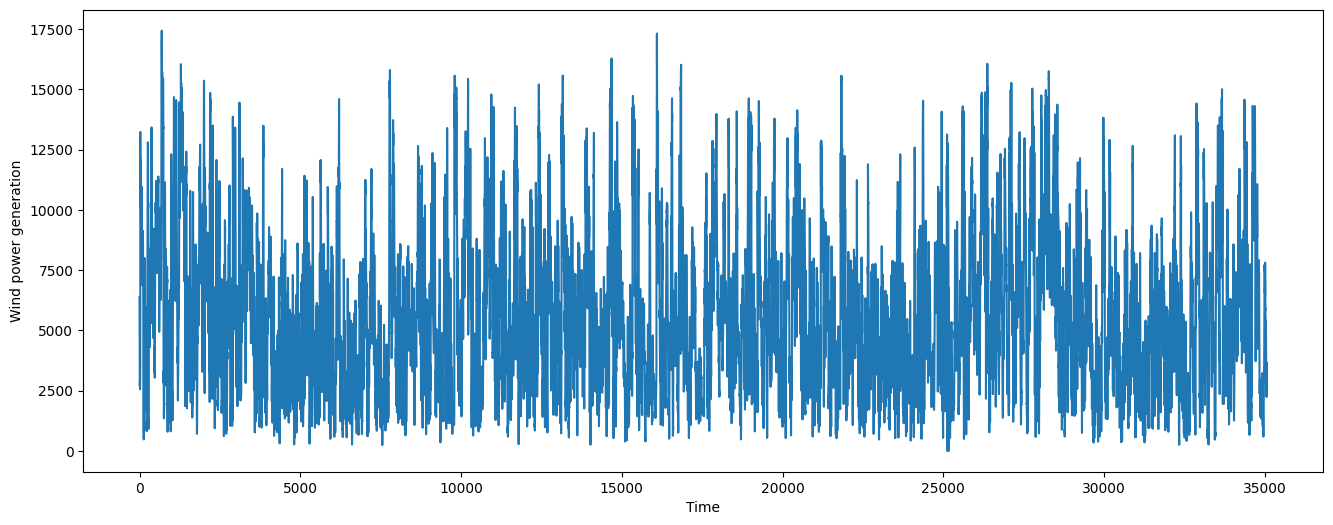

In [80]:
plt.figure(figsize=(16, 6))
plt.plot(df_actual)
plt.xlabel('Time')
plt.ylabel('Wind power generation')

## 7. Model building and training and evaluating

In [81]:
# Testing For Stationarity

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(data):
  result=adfuller(data)
  labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
  for value,label in zip(result,labels):
      print(label+' : '+str(value) )
  if result[1] <= 0.05:
      print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
  else:
      print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(df_actual)


ADF Test Statistic : -17.95593408973521
p-value : 2.827896313944181e-30
#Lags Used : 49
Number of Observations Used : 35014
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [82]:
scaler = MinMaxScaler(feature_range=(0,1))
df_actual = scaler.fit_transform(np.array(df_actual).reshape(-1,1))


In [83]:
# splitting dataset into train and test split
training_size = int(len(df_actual)*0.80)
test_size = len(df_actual) - training_size
train_data, test_data = df_actual[0:training_size,:], df_actual[training_size:len(df_actual),:1]

In [84]:
len(df_actual) - training_size

7013

In [41]:
#len(df_actual) - training_size

7714

In [85]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):

  dataX, dataY = [], []

  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])

  return np.array(dataX), np.array(dataY)


In [86]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape, y_train.shape)
print(X_test.shape, ytest.shape)

(27950, 100) (27950,)
(6912, 100) (6912,)


In [87]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [88]:
# Create the Stacked LSTM model

model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [89]:
model.fit(X_train, y_train, validation_data = (X_test, ytest), epochs = 10, batch_size = 64, verbose = 1)

Epoch 1/10
437/437 [==============================] - 90s 194ms/step - loss: 0.0076 - val_loss: 0.0019
Epoch 2/10
437/437 [==============================] - 83s 191ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 3/10
437/437 [==============================] - 87s 200ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/10
437/437 [==============================] - 83s 190ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5/10
437/437 [==============================] - 84s 191ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/10
437/437 [==============================] - 83s 189ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 7/10
437/437 [==============================] - 83s 189ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/10
437/437 [==============================] - 84s 192ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/10
437/437 [==============================] - 92s 211ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/10
437/437 [==============================] - 84s 192ms/step - l

In [90]:
# Do the prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

216/216 [==============================] - 9s 42ms/step


In [91]:
# Calculate RMSE performance metrics

# Test Data RMSE
math.sqrt(MSE(ytest, test_predict))

0.03308935144360294

In [93]:
# Test Data RMSE
math.sqrt(MSE(ytest, scaler.fit_transform(np.array(df_merged['forecast wind onshore day ahead']).reshape(-1,1))[-6912:]))

0.0482348089864966

In [94]:
### Test Data RMSE
math.sqrt(MSE(scaler.inverse_transform(ytest.reshape(-1,1)), scaler.inverse_transform(test_predict)))

568.9052155089583

In [95]:
math.sqrt(MSE(scaler.inverse_transform(ytest.reshape(-1,1)), df_merged['forecast wind onshore day ahead'][-6912:]))

829.301070904836

In [96]:
df_merged['generation wind onshore']

0        6378.0
1        5890.0
2        5461.0
3        5238.0
4        4935.0
          ...  
35059    3113.0
35060    3288.0
35061    3503.0
35062    3586.0
35063    3651.0
Name: generation wind onshore, Length: 35064, dtype: float64

In [97]:
df_merged['forecast wind onshore day ahead']

0        6436.0
1        5856.0
2        5454.0
3        5151.0
4        4861.0
          ...  
35059    3253.0
35060    3353.0
35061    3404.0
35062    3273.0
35063    3117.0
Name: forecast wind onshore day ahead, Length: 35064, dtype: float64

In [98]:
# forecast_data_wind = scaler.fit_transform(np.array(forecast_data['forecast wind onshore day ahead']).reshape(-1,1))
forecast_data_wind = scaler.fit_transform(np.array(df_merged['forecast wind onshore day ahead']).reshape(-1,1))

### Test Data RMSE
math.sqrt(MSE(ytest, forecast_data_wind[-6912:]))

0.0482348089864966

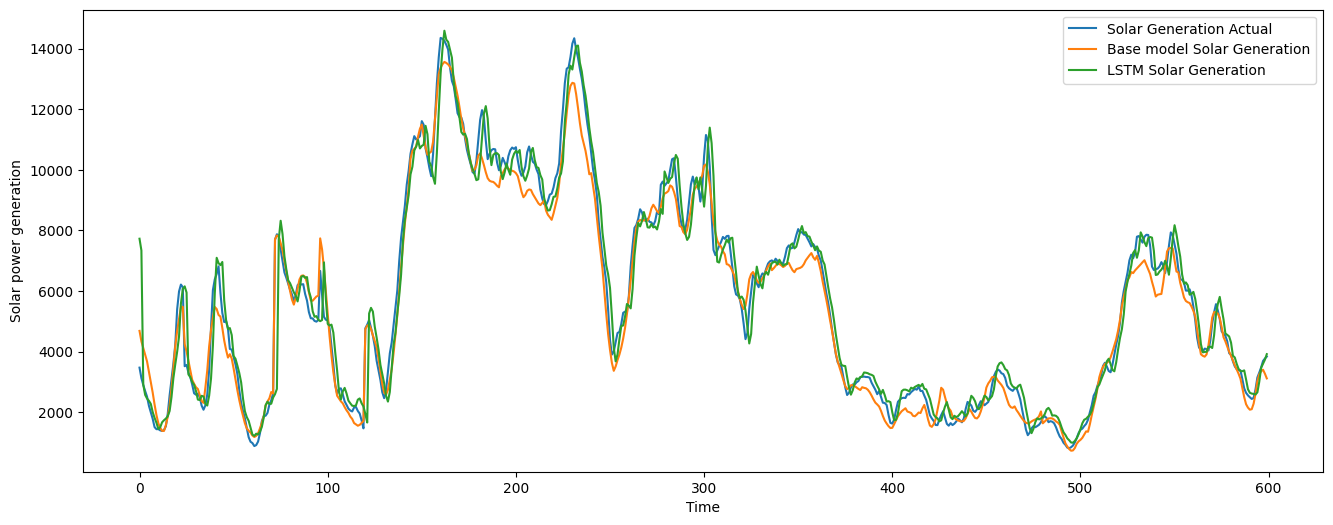

In [99]:
# test_predict = scaler.inverse_transform(test_predict)
plt.figure(figsize=(16, 6))
plt.plot(scaler.inverse_transform(df_actual[-600:]), label = "Solar Generation Actual")
plt.plot(scaler.inverse_transform(forecast_data_wind[-600:]), label = "Base model Solar Generation")
plt.plot(scaler.inverse_transform(test_predict)[-600:], label = "LSTM Solar Generation")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Solar power generation')
plt.show()

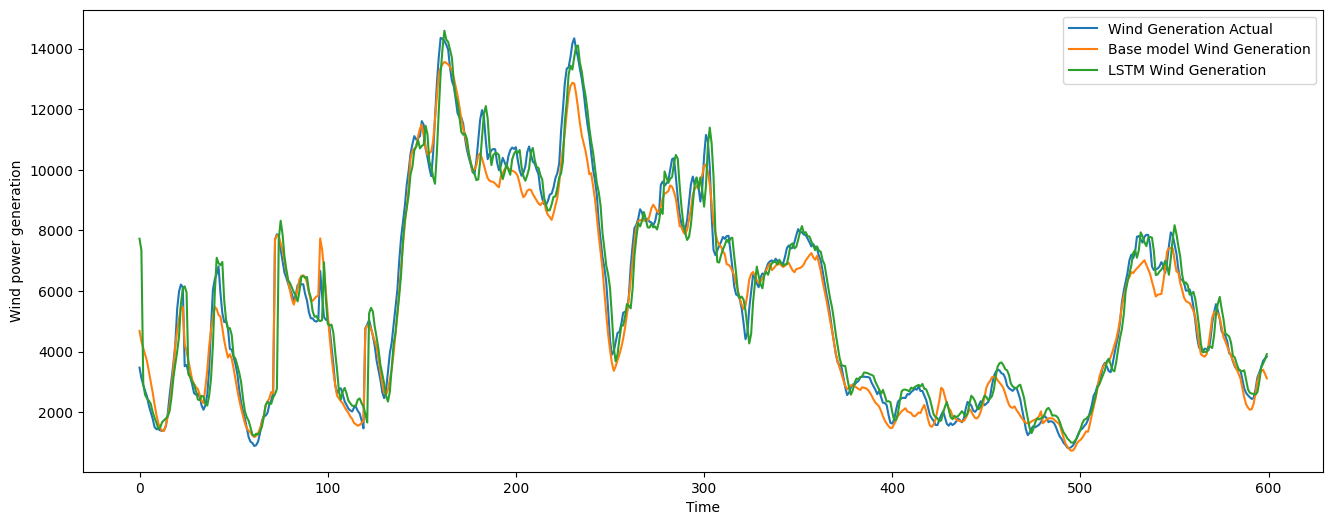

In [100]:
# test_predict = scaler.inverse_transform(test_predict)
plt.figure(figsize=(16, 6))
plt.plot(scaler.inverse_transform(df_actual[-600:]), label = "Wind Generation Actual")
plt.plot(scaler.inverse_transform(forecast_data_wind[-600:]), label = "Base model Wind Generation")
plt.plot(scaler.inverse_transform(test_predict)[-600:], label = "LSTM Wind Generation")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Wind power generation')
plt.show()

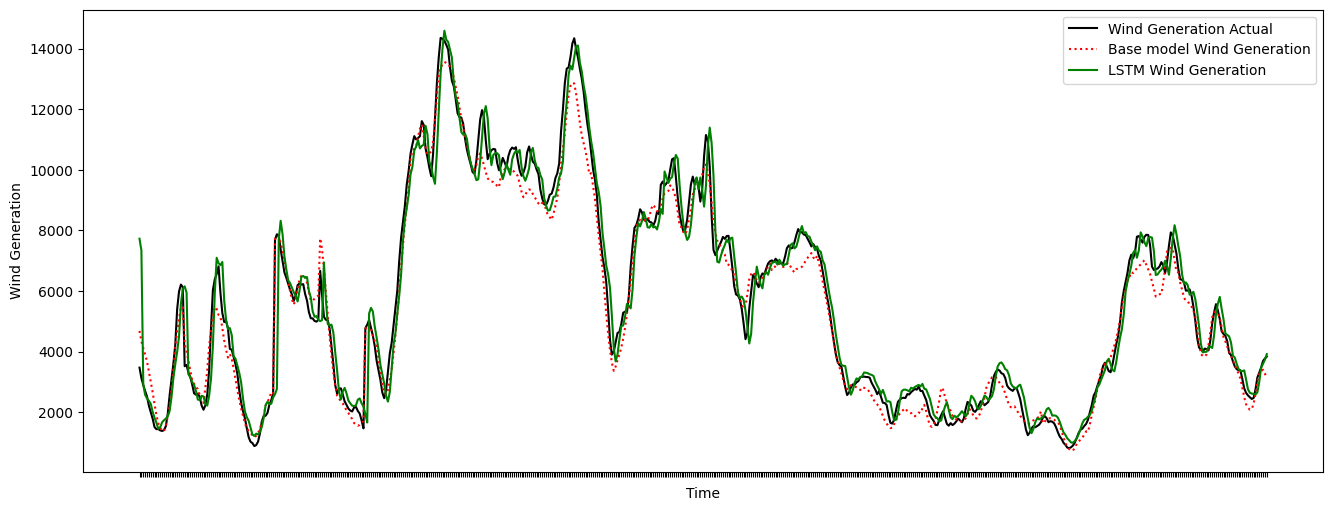

In [101]:
plt.figure(figsize=(16, 6))
plt.plot(scaler.inverse_transform(df_actual[-600:]), label = "Wind Generation Actual", color = 'black')
plt.plot(scaler.inverse_transform(forecast_data_wind[-600:]), linestyle='dotted', label = "Base model Wind Generation", color = 'red')
plt.plot(scaler.inverse_transform(test_predict)[-600:], label = "LSTM Wind Generation", color = 'green')

x_ticks = range(len(df_actual[-600:]))
plt.xticks(x_ticks, [''] * len(x_ticks))  # Empty labels for x-axis
plt.legend()
plt.xlabel('Time')
plt.ylabel('Wind Generation')
plt.show()